In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

In [2]:
def bt_mix(r1, r2, allocator, **kwargs): # Allocator is a variable that points to a function; Key-Words Arguments
    """
    Runs as back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios.
    """
    if not r1.shape == r2.shape:
        raise ValueError('r1 and r2 need to be the same shape')
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError('Allocator returned weights that dont martch r1')
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [3]:
# Let's write a fixed mix allocator:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    '''
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
        each column is a scenario
        each row is the price of a timestep
    Returns an T x N DataFrame of PSP weights
    '''
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [4]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_bonds = bt_mix(rets_10, rets_30, allocator = fixedmix_allocator, w1 = .6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035801,0.003431,0.049813,3.291425,-0.001333,-0.000808,1.645445,0.0


In [5]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [6]:
# Create a portfolio composed of equities and bonds
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis='columns') # Mean return of 500 scenarios (it's a composite)
erk.summary_stats(pd.DataFrame(rets_7030b_mean))
# Sharpe Ratio is much higher compared to 60/40 short and long bonds

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.058827,0.004397,0.208752,2.737255,-0.002766,-0.002424,6.38036,0.0


In [7]:
summaries = erk.summary_stats(rets_7030b)
summaries.head()

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.056342,0.098027,-0.385341,2.981141,0.044387,0.056784,0.261419,-0.169410
1,0.090618,0.101098,0.405266,2.886013,0.036754,0.041918,0.583480,-0.109092
2,0.073166,0.111641,0.132631,3.248345,0.044994,0.059429,0.376193,-0.182995
3,0.088375,0.112669,0.012521,2.668337,0.045773,0.056859,0.504148,-0.168239
4,0.037014,0.103279,0.171915,3.046843,0.043866,0.055310,0.065972,-0.186920


In [8]:
summaries.mean()

Annualized Return          0.053290
Annualized Volatility      0.107369
Skewness                  -0.019035
Kurtosis                   2.997732
Cornish-Fisher VaR (5%)    0.046123
Historic CVaR (5%)         0.058784
Sharpe Ratio               0.212493
Max Drawdown              -0.205529
dtype: float64

Different ways to create the composite.
1st is to do the mean across all scenarios
2nd is to do the mean across each statistic derived from each scenario

In [9]:
def terminal_values(rets):
    '''
    Returns the final values of a dollar at the end of the return period for each scenario
    '''
    return (rets+1).prod()

In [10]:
def terminal_stats(rets, floor=0.8, cap=np.inf, name='Stats'):
    '''
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    Rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Statistics indexed by the start name
    '''
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = breach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        'mean': terminal_wealth.mean(),
        'std': terminal_wealth.std(),
        'p_breach': p_breach,
        'e_short': e_short,
        'p_reach': p_reach,
        'e_surplus': e_surplus
    }, orient='index', columns=[name])
    return sum_stats

In [11]:
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='EQ'),
    erk.terminal_stats(rets_7030b, name='70/30')
], axis=1)

,FI,EQ,70/30
mean,1.382744,1.928738,1.757855
std,0.108863,0.974289,0.590973
p_breach,NaN,0.036000,0.004000
e_short,NaN,0.112804,0.063148
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


For Equities, there is a 3% chance to breach the floor at the terminal date.
e_short is the average of all scenarios of how much you miss the floor.
Here, since the floor is 80%, meaning 0.80 cents, in average we end up at 80%-11% = 69% or 0.69 cents.

C:\Users\Mikael\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mikael\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mikael\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

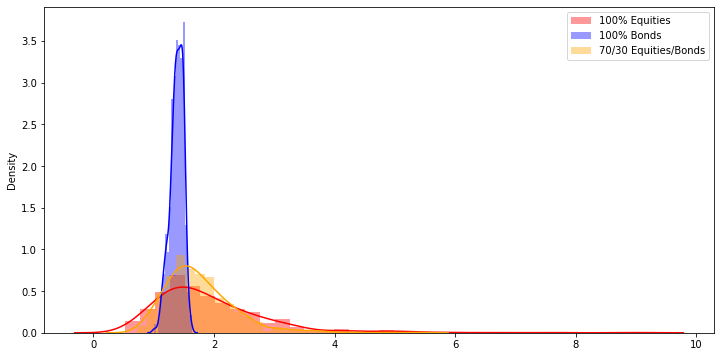

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color='red', label='100% Equities')
sns.distplot(erk.terminal_values(rets_bonds), color='blue', label='100% Bonds')
sns.distplot(erk.terminal_values(rets_7030b), color='orange', label='70/30 Equities/Bonds')
plt.legend();

We want to eliminate the cases where we are below 1 on the X-axis (meaning we cannot fulfill our liability)

# Glide Paths For Allocation

In [17]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    '''
    Simulates a Target-Date-Fund style gradual move from r1 to r2
    '''
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1) # Replicates our column
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [19]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='EQ'),
    erk.terminal_stats(rets_7030b, name='70/30'),
    erk.terminal_stats(rets_g8020, name='Glide Path 80 to 20')
], axis=1)

,FI,EQ,70/30,Glide Path 80 to 20
mean,1.382744,1.928738,1.757855,1.634934
std,0.108863,0.974289,0.590973,0.406749
p_breach,NaN,0.036000,0.004000,0.002000
e_short,NaN,0.112804,0.063148,0.002476
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN
